In [24]:
import torch
from src.k_tree import Ktree
from src.utils.data import loadData_3d
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
data, _ = loadData_3d(1000, 100)
#data = np.load('./data_3d/10000cb/100cb_1_4.npy')

learning_rate = 5e-3 # 1e-2
k = 4
teacher_args = {
    "optimizer_lr": learning_rate,
    "epochs": 100, # 200
    "times": 10,
    "alpha": 10, # 5
    "beta": 5,
    "number_of_centroids": k
}
n = 20
un_args = {
    "N": n,# 30,20
    "M": n**3-1, # 10000 - 1
    "epsilon": 0.14 # here a layer value should be somehow included. As layers get denser  epilson should be smaller
}
student_args = {
    "optimizer_lr": 5e-3,
    "epochs": 2000, # 30000
    "width": 100, # 100
    "depth": 3, # 3
}

threshold = 0.1 * len(data) if len(data) > 500 else 30*len(data)
stop_criterion = 50 if len(data) > 500 else 
#threshold = 30
ktree = Ktree(threshold, data, teacher_args, un_args, student_args, 3)
print("="*20)
print("Start training")
print("="*20)
ktree.create_tree(save_path_prefix="models/cuboids/1000/class")

Loading data...
Data loaded.
Start training
Creating student for node 0 that has 1000 data, which is more than the threshold 30.
Bounding box for node 0: [[42, 956], [42, 957], [42, 957]]
Creating teacher for node 0 with 4 centroids.
Training Teacher Model
Epoch: 10/100..  Training loss: 717394.56250..  Reg Proj: 1171.91443..  Reg Latent: 22.96969..  Memory: 705560.56250..  Cost: 717394.56250.. 
Epoch: 20/100..  Training loss: 555952.31250..  Reg Proj: 0.00000..  Reg Latent: 91.38131..  Memory: 555495.37500..  Cost: 555952.31250.. 


KeyboardInterrupt: 

## Debug UN 3d

(27, 9)
(27, 9)
(33, 9)
(13, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
f shape: torch.Size([6338])
label shape: torch.Size([6338])
points shape: (6338, 3)
min_z: -6.0
max_z: 307.0


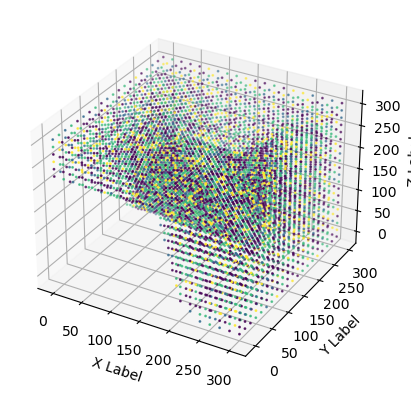

In [19]:
root = ktree.root
children = root.children
# print all children data shapes
for child in children:
    print(child.data.shape)

labels = root.un_labels
e = root.un_energy
points = root.un_points
f, label = e.min(1)
print(f'f shape: {f.shape}')
print(f'label shape: {label.shape}')
print(f'points shape: {points.shape}')

z_ax = points[:,2]
# get max and min of z_ax
min_z = z_ax.min()
max_z = z_ax.max()
# print
print(f'min_z: {min_z}')
print(f'max_z: {max_z}')

# plot points with label
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], c=label,s=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
#ax.view_init(azim=0, elev=90)

plt.show()

In [20]:
times = 0
end = 10
mean_acc = 0
best_acc = 0
wost_acc = 100
wanna_plot = False
while times < end:
    times+=1
    # random n querry points
    n = 100    
    random_p = torch.zeros(n, 3)
    x_lim = [0,300]
    y_lim = [0,300]
    z_lim = [0,300]

    for i in range(n):
        x = np.random.uniform(x_lim[0],x_lim[1])
        y = np.random.uniform(y_lim[0],y_lim[1])
        z = np.random.uniform(z_lim[0],z_lim[1])
        random_p[i] = torch.Tensor([x, y, z])
    infer_points = random_p.to(device)
    if wanna_plot:
        # plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(random_p[:,0], random_p[:,1], random_p[:,2], c='royalblue',s=1)
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        #ax.view_init(azim=0, elev=90)
        plt.show()
    num_of_correct_predictions = 0
    wanna_print = False 
    for query_point in infer_points:
        pred = ktree.query(query_point)
        brute_force = ktree.root.query(query_point)
        if np.array_equal(pred, brute_force):
            num_of_correct_predictions += 1
        else:
            if wanna_print:
                print(f'Query: {query_point}')
                print(f'Brute force prediction: {brute_force}')
                print(f'Prediction from student model: {pred}')
                print()
    acc = (num_of_correct_predictions / len(infer_points)) * 100
    print(f"The percentage of correct predictions is {acc}%")
    if acc > best_acc:
        best_acc = acc
    if acc < wost_acc:
        wost_acc = acc
    mean_acc += acc

print(f"Worst acc: {wost_acc}")
print(f"Mean acc: {mean_acc/end}")
print(f"Best acc: {best_acc}")

The percentage of correct predictions is 87.0%
The percentage of correct predictions is 86.0%
The percentage of correct predictions is 87.0%
The percentage of correct predictions is 89.0%
The percentage of correct predictions is 87.0%
The percentage of correct predictions is 85.0%
The percentage of correct predictions is 86.0%
The percentage of correct predictions is 86.0%
The percentage of correct predictions is 81.0%
The percentage of correct predictions is 86.0%
Worst acc: 81.0
Mean acc: 86.0
Best acc: 89.0


added: 1000


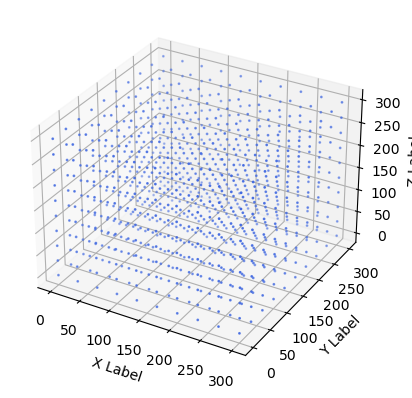

In [21]:
# also get points
base = 10
nop = base**3    # 512 points.
random_p = torch.zeros(nop, 3)
x_lim = [0,300]
y_lim = [0,300]
z_lim = [0,300]
added = 0
for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], base)):
    for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], base)):
        for k, z in enumerate(np.linspace(z_lim[0],z_lim[1], base)):
            index = i * (base ** 2) + j * base + k
            random_p[index] = torch.Tensor([x, y, z])
            added +=1
print(f'added: {added}')
 
infer_points = random_p.to(device)
# plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(infer_points[:,0], infer_points[:,1], infer_points[:,2], c='royalblue',s=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
#ax.view_init(azim=0, elev=90)
plt.show()

In [22]:
num_of_correct_predictions = 0
wanna_print = False 
for query_point in infer_points:
    pred = ktree.query(query_point)
    brute_force = ktree.root.query(query_point)
    if np.array_equal(pred, brute_force):
        num_of_correct_predictions += 1
    else:
        if wanna_print:
            print(f'Query: {query_point}')
            print(f'Brute force prediction: {brute_force}')
            print(f'Prediction from student model: {pred}')
            print()
print(f"The percentage of correct predictions is {(num_of_correct_predictions / len(infer_points)) * 100:.2f}%")

The percentage of correct predictions is 85.40%


torch.Size([1000])


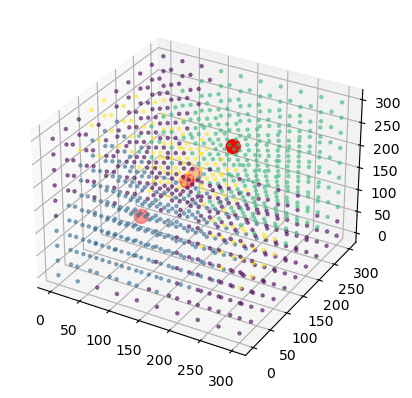

In [23]:
pred_z = ktree.root.student(infer_points).argmax(1)
print(pred_z.shape)
# plot with pred_z label
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(infer_points[:,0], infer_points[:,1], infer_points[:,2], c=pred_z,s=5,alpha=0.5)
# =======
res = np.load('./models/cuboids/1000/class0_teacher_training_results.npy', allow_pickle=True).item()
centroids = res['best_outputs'].detach().cpu().numpy()
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], c='r', marker='o', s=100)

plt.show()

## Inference

In [ ]:
# Print a student prediction both using the student model from training
# and the student model loaded from config. The two outputs should be equal.
query = torch.tensor([[4., 2., 0.], [2., 0., -2.]]).to(device)

pred_trained = ktree.root.student(query)
print(pred_trained)

# Recreate the student model from config.
node = Ktree.Node(ktree.root.data, "", ktree, None)
node.create_student_from_config("models/cuboids/1000/class0_student_config.pt")
pred_config = node.student(query)
print(pred_config)

print("Predictions are " + "equal." if torch.equal(pred_trained, pred_config) else "NOT equal.")